## Logreg + new data + extract features
- default
- topic words
- only NER?
- only pos
- only syntax
- only stop-words

In [1]:
from utils import import_dataset, get_scores, classes, label2id, feature_extraction, stopwords
import pandas as pd
from numpy import mean, std
from tqdm.notebook import tqdm
import time
from datasets import load_dataset, concatenate_datasets
import pickle
CLASSES = classes

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.chunk import ne_chunk

import spacy_udpipe
# spacy_udpipe.download("en") # download English model
nlp = spacy_udpipe.load("en")

/home/valeria/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
def posify(data):
    return [' '.join([t[1] for t in pos_tag(word_tokenize(sent), tagset='universal')]) for sent in data]


def posify_word(data):
    return [' '.join([f'{t[0]}_{t[1]}' for t in pos_tag(word_tokenize(sent), 
                                                        tagset='universal')]) for sent in data]

    
def posify_separately(data):
    
    new_data = []

    for par in data: 
        new_par = []
        for sent in sent_tokenize(par): # 
            tags = pos_tag(word_tokenize(sent))
            tags = ' '.join([t[1] for t in tags])
            new_sent = sent + ' ' + tags
            new_par.append(new_sent)
            
        new_data.append(' '.join(new_par))
        
    return new_data

# posify_separately(['Hi! My name is Dan.', 'My name is Jared. I am 18. I never fucking learned how to read.'])


def dependencies(data, pos_=False):
    new_data = []
    
    for par in tqdm(data):
        new_par = []
        for sent in sent_tokenize(par):
            doc = nlp(sent)
            if pos_:
                new_sent = ' '.join([f'{token.dep_}_{token.pos_}' for token in doc])
            else:
                new_sent = ' '.join([token.dep_ for token in doc])
            new_par.append(new_sent)
        new_data.append(' '.join(new_par))
        
    return new_data

# dependencies(['Hi! My name is Dan.', 'My name is Jared. I am 18. I never fucking learned how to read.'], pos_=True)


def remove_ner(data):

    new_data = []
    
    for par in data:
        
        new_par = ''
        
        for sent in sent_tokenize(par): # !
            new_sentence = ''
            for chunk in ne_chunk(pos_tag(word_tokenize(sent))):
                if hasattr(chunk, 'label'):
                    new_sentence += f'#{chunk.label()}'
                else:
                    new_sentence += chunk[0]
                new_sentence += ' '
            new_par += new_sentence
#             new_par += ' '
        
        new_data.append(new_par)
            
        
    # пробелы после знаков препинания...
    
    
    return new_data
            
# remove_ner(['Hello! My name is Dan.', 'I live in London.'])

In [3]:
def collect_dataset(seed, 
                    vectorizer=TfidfVectorizer(max_features=5000), 
                    save_vect=False, 
                    preproc=False, 
                    history_data='random'):
    
    # returns preprocessed train, test and essays in history test set; trained vectorizer
    
    # main dataset
    dataset = import_dataset(seed, history_data)
    
    y_train = dataset['train']['labels']
    y_test = dataset['test']['labels']
    
    x_train = dataset['train']['text']  
    x_test = dataset['test']['text']
    
    if preproc=='pos':
        x_train = posify(x_train)
        x_test = posify(x_test)
    elif preproc=='pos_word':
        x_train = posify_word(x_train)
        x_test = posify_word(x_test)
    elif preproc == 'pos_sep':
        x_train = posify_separately(x_train)
        x_test = posify_separately(x_test)
    elif preproc == 'ner':
        x_train = remove_ner(x_train)
        x_test = remove_ner(x_test)
    elif preproc == 'dep':
        x_train = dependencies(x_train)
        x_test = dependencies(x_test)
    elif preproc == 'dep_pos':
        x_train = dependencies(x_train, True)
        x_test = dependencies(x_test, True)
    
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    
    # essays in history
    eh_dataset = load_dataset('json', data_files='hume_json/essays_in_history.json')
    
    x_eh_test = vectorizer.transform(eh_dataset['train']['text'])
    y_eh_test = eh_dataset['train']['labels']
    
    if save_vect:
        with open('models/tfidf_vectorizer.pkl','wb') as f:
            pickle.dump(vectorizer, f)
    
    return x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, vectorizer

In [4]:
def run_model(model, 
              title, 
              data=(),
              seed=13,
              matrix=True, 
              print_accuracy=True,
              collect_mistakes=False,
              test_eh=True):
    
    if not data:
        data = collect_dataset(seed)
    
    x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, _ = data
    
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    eh_pred = model.predict(x_eh_test)

    if test_eh:
        eh_accuracy, _ = get_scores(eh_pred, y_eh_test, title='essay-history', matrix=True, print_=False)
        print(f'Accuracy on essays in history: {100 - eh_accuracy:.2f}')

    accuracy, _ = get_scores(pred, y_test, title=title, matrix=matrix, print_=print_accuracy, prec_rec=True)
                
                
    if collect_mistakes:
        mistakes = []
    
        for i in range(len(y_test)):
            t = y_test[i]
            p = pred[i]

            if t != p:
                mistakes.append((CLASSES[t], CLASSES[p], dataset['test'][i]['title'], dataset['test'][i]['text']))

        df = pd.DataFrame(mistakes, columns=['true', 'predicted', 'title', 'text'])
        out['mistakes'] = df

## Experiments

Accuracy on essays in history: 74.63
Accuracy: 76.29
History precision: 97.22
History recall: 100.00
Training time: 2.151242733001709 s


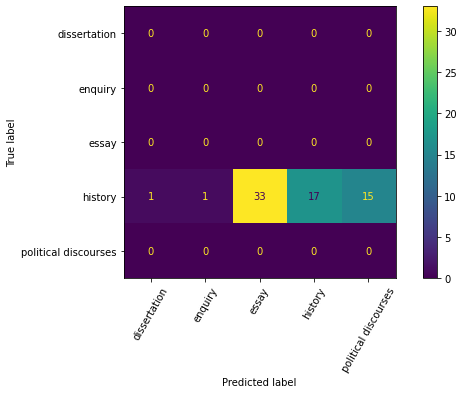

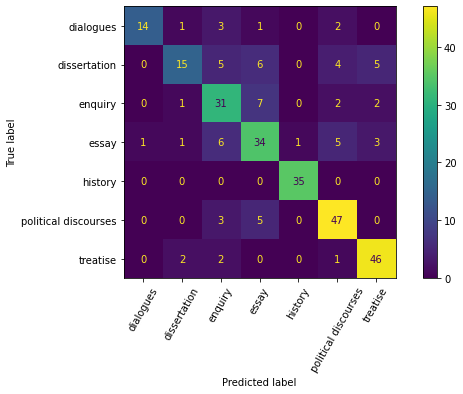

In [6]:
# default model

vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic')
model = LogisticRegression()
start = time.time()
run_model(model, 'Logreg default', data=data)
print(f'Training time: {time.time()-start} s')
feature_extraction(model, vectorizer, 'logreg_default')

Accuracy on essays in history: 91.04
Accuracy: 80.07
History precision: 97.22
History recall: 100.00
Training time: 1.1295311450958252 s


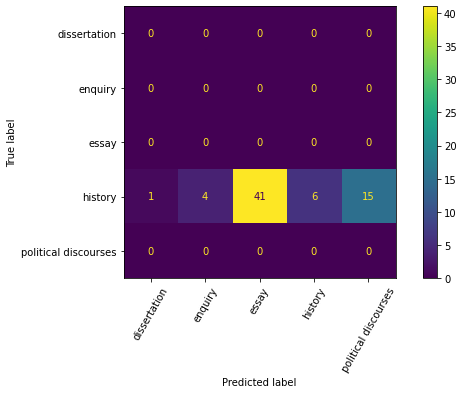

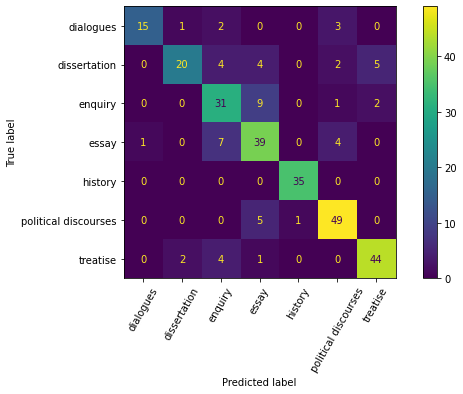

In [5]:
# only topic words

vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords)
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic')
model = LogisticRegression()
start = time.time()
run_model(model, 'logreg topic words', data=data)
print(f'Training time: {time.time()-start} s')
feature_extraction(model, vectorizer, 'logreg_topic_words')

Accuracy on essays in history: 67.16
Accuracy: 48.11
History precision: 89.74
History recall: 100.00
Training time: 0.1520678997039795 s


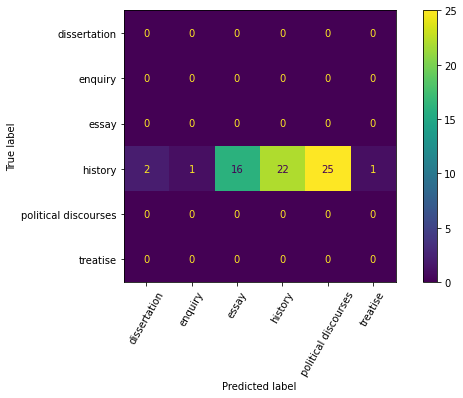

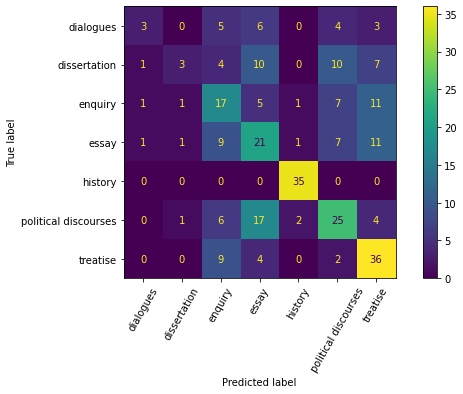

In [7]:
# only stopwords

vectorizer = TfidfVectorizer(max_features=5000, vocabulary=stopwords)
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic')
model = LogisticRegression()
start = time.time()
run_model(model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')
feature_extraction(model, vectorizer, 'logreg_stop_words')

Accuracy on essays in history: 100.00
Accuracy: 44.67
History precision: 85.37
History recall: 100.00
Training time: 0.29024219512939453 s


/home/valeria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


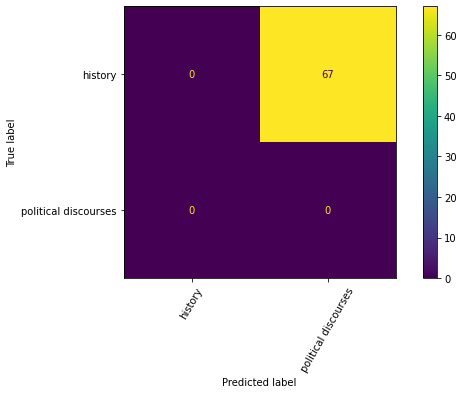

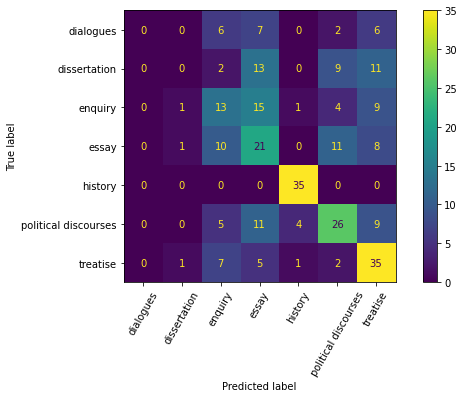

In [8]:
# only pos

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic', preproc='pos')
model = model = LogisticRegression()
start = time.time()
run_model(model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')
feature_extraction(model, vectorizer, 'logreg_pos')

  0%|          | 0/2324 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

Accuracy on essays in history: 100.00
Accuracy: 51.20
History precision: 92.11
History recall: 100.00
Training time: 4.956438779830933 s


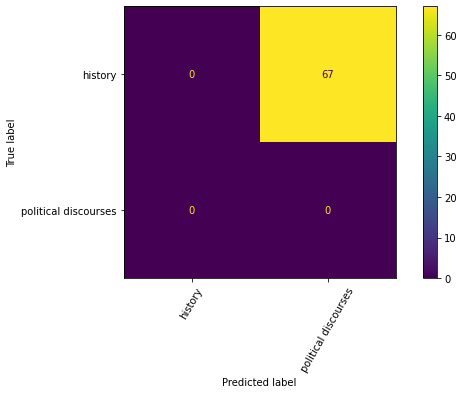

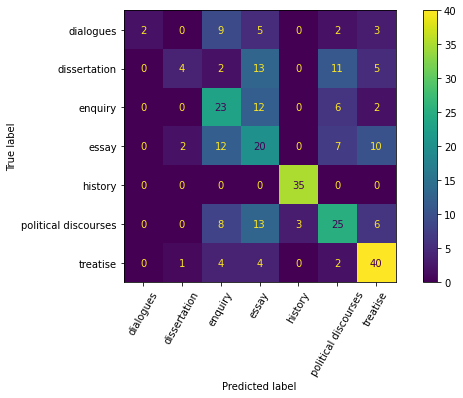

In [9]:
# only syntax

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic', preproc='dep')
model = model = LogisticRegression()
start = time.time()
run_model(model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')
feature_extraction(model, vectorizer, 'logreg_syntax')